In [10]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import talib

In [11]:
# 显示所有列
#pd.set_option('display.max_columns', None)
#pd.set_option('max_colwidth',200)  # 只显示50个
#pd.set_option('display.max_rows', None)  # 行
pd.options.display.max_rows = 20

In [12]:
path_root = os.getcwd()
os.getcwd()
filename = os.listdir(path_root + "/datas/hs300m")
maxstocknum = 2  # 股票池最大股票数目
filename = filename[0:maxstocknum]
# 设置测试时间
back_year = 3
end = dt.datetime.now()
sta = dt.datetime.now() - dt.timedelta(days=back_year * 60)
# 创建交易数据集
fname='SH#600519.csv'
df = pd.read_csv(path_root + "/datas/hs300m/" + fname, dtype='str', encoding="gbk", skiprows=[0, 1], skipfooter=1,
                 names=['datetimes', 'times', 'open', 'high', 'low', 'close', 'volume', 'amount'])
df=df.tail(2000)
df['datetime'] = df['datetimes'] + " " + df['times']
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
df.drop(['datetime', 'datetimes', 'times'], axis=1, inplace=True)
df[['open', 'high', 'low', 'close','volume','amount']] = df[['open', 'high', 'low', 'close','volume','amount']].astype('float')


<ipython-input-12-e9b44a3c2809>:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path_root + "/datas/hs300m/" + fname, dtype='str', encoding="gbk", skiprows=[0, 1], skipfooter=1,


In [13]:
df['macd'],df['macdsignal'],macdhist=talib.MACDEXT(df['close'],fastperiod=12,slowperiod=26,signalperiod=9)
df['slowk'],df['slowd']=talib.STOCH(df['high'],df['low'],df['close'],fastk_period=9,slowk_period=3,slowd_period=3)
#df['slowj'] = list(map(lambda x,y: 3*x-2*y, df['slowk'], df['slowd']))


In [14]:
def cross_over(line1,line2):
    up=line1>line2
    down=line1<line2
    up_position=up.shift(1)
    down_position=down.shift(1)
    cross_up=np.where(up & down_position,1,0)
    cross_down=np.where(down & up_position,-1,0)
    cross=cross_up+cross_down
    return cross

df['macd_cross']=cross_over(df['macd'],df['macdsignal'])


df1=df.loc[df['macd_cross']!=0][['close','macd','macd_cross']]
pnl=df1['close']-df1['close'].shift(-1)
df1['pnl']=pnl

In [15]:
#数据标准版
def stand(factor):
  """自实现标准化
  """
  mean = factor.mean()
  std = factor.std()
  return (factor - mean)/std

df1['macd_stand']=stand(df1['macd'])
df1.corr('pearson')


,close,macd,macd_cross,pnl,macd_stand
close,1.000000,0.186091,-0.007876,0.153285,0.186091
macd,0.186091,1.000000,-0.471745,0.109108,1.000000
macd_cross,-0.007876,-0.471745,1.000000,-0.035852,-0.471745
pnl,0.153285,0.109108,-0.035852,1.000000,0.109108
macd_stand,0.186091,1.000000,-0.471745,0.109108,1.000000


<AxesSubplot:xlabel='macd_stand', ylabel='pnl'>

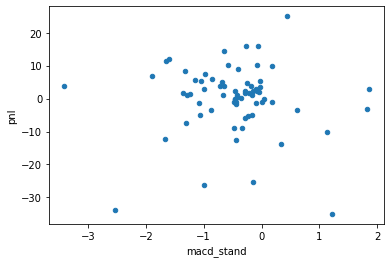

In [16]:
#macd金叉与收益的散点图
df1.loc[df1['macd_cross']==1].plot.scatter(x='macd_stand',y='pnl')

In [18]:
df2=pd.DataFrame()
df2['close']=stand(df['close'])
df2['volume']=stand(df['volume'])
df2['amount']=stand(df['amount'])
df2.corr('pearson')

,close,volume,amount
close,1.000000,0.131355,0.154100
volume,0.131355,1.000000,0.999405
amount,0.154100,0.999405,1.000000
